# Predicting Hotel Booking Cancellations
## Pre-processing and Training Data Development

## 1. Introduction

This is the third notebook of my **Predicting Hotel Booking Cancellations** project. In this part we are manipulating our data to prepare it for our ML modeling from our final part.

The notebook will develop around these main focuses:
* Data Leakage analysis
* Feature engineering, that will include dealing with categorical features, scaling, dimensionality reduction.
    * Adding new features
    * Binning categorical data
    * One-hot encoding
    * **Train-test-split**

* Customer segmentation through unsupervised learning - KMeans
    * scaling
    * PCA
    * Assessing clustering
        * Silhouette
        * Elbow

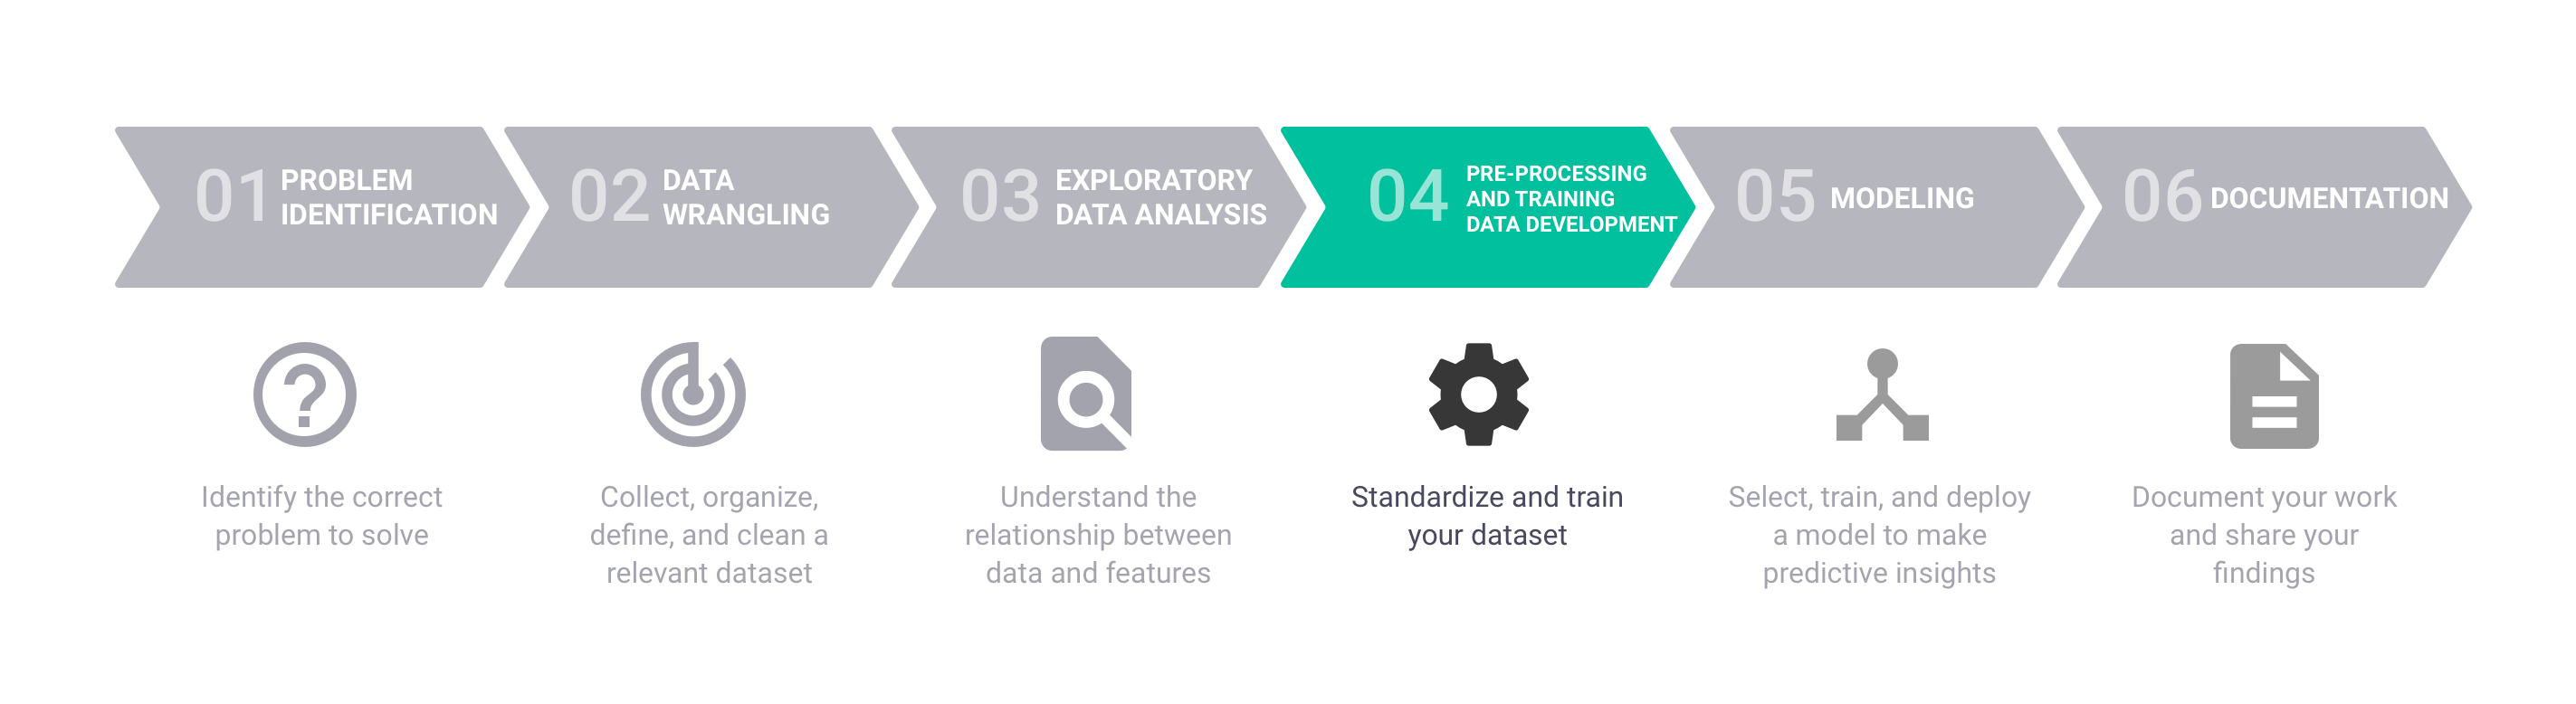

## 2. Data Leakage analysis 

Before proceeding we need to investigate a problem that can come across any Data Science project - **Data Leakage**. So we have to go back on our data's [source](https://www.sciencedirect.com/science/article/pii/S2352340918315191?via%3Dihub) and analyze what the authors had to say about this.

> **One of the most important properties in data for prediction models is not to promote leakage of future information. 
<br><br>In order to prevent this from happening, the timestamp of the target variable must occur after the input variables’ timestamp. Therefore, instead of directly extracting variables from the bookings database table, when available, the variables’ values were extracted from the bookings change log, with a timestamp relative to the day prior to arrival date (for all the bookings created before their arrival date).**

So when data was collected they tried to prevent data leakage as much as possible,but some features were definitely affected by it because of the industry particularities.

> **In hotel industry it is quite common for customers to change their booking׳s attributes, like the number of persons, staying duration, or room type preferences, either at the time of their check-in or during their stay. It is also common for hotels not to know the correct nationality of the customer until the moment of check-in. Therefore, even though the capture of data took considered a timespan prior to arrival date, it is understandable that the distribution of some variables differ between non canceled and canceled bookings.** 

In [1]:
#Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 6)
import seaborn as sns
sns.set_theme(style="whitegrid")

from scipy import stats
 
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn import __version__ as sklearn_version
import pickle
import datetime

In [2]:
#Loading the data from the 2 hotels
hotels = pd.read_csv('../data/interim/hotels_cleaned.csv', index_col = 0)

>We will create a short function for replacing the least common categorical values from a given feature if those values appear less then a threshold.

In [3]:
def least_categ_replace(feature, tresh):
    feature_counts = hotels[feature].value_counts()
    mask = hotels[feature].isin(feature_counts[feature_counts <tresh].index)
    hotels.loc[mask, feature] = 'Other'
    print(hotels[feature].value_counts())

In [4]:
hotels.describe(exclude='O').T

,count,mean,std,min,25%,50%,75%,max
is_canceled,119389.0,0.370411,0.482917,0.00,0.00,0.00,1.0,1.0
lead_time,119389.0,104.011994,106.863358,0.00,18.00,69.00,160.0,737.0
arrival_date_year,119389.0,2016.156555,0.707479,2015.00,2016.00,2016.00,2017.0,2017.0
arrival_date_week_number,119389.0,27.165292,13.605134,1.00,16.00,28.00,38.0,53.0
arrival_date_day_of_month,119389.0,15.798164,8.780826,1.00,8.00,16.00,23.0,31.0
stays_in_weekend_nights,119389.0,0.927606,0.998614,0.00,0.00,1.00,2.0,19.0
stays_in_week_nights,119389.0,2.500314,1.908289,0.00,1.00,2.00,3.0,50.0
adults,119389.0,1.856402,0.579263,0.00,2.00,2.00,2.0,55.0
children,119389.0,0.103887,0.398557,0.00,0.00,0.00,0.0,10.0
babies,119389.0,0.007949,0.097437,0.00,0.00,0.00,0.0,10.0


In [5]:
hotels.describe(include='O').T

,count,unique,top,freq
hotel,119389,2,Lisbon City Hotel,79329
arrival_date_month,119389,12,August,13877
meal,119389,5,BB,92309
country,119389,178,PRT,48589
market_segment,119389,8,Online TA,56477
distribution_channel,119389,5,TA/TO,97869
reserved_room_type,119389,10,A,85993
assigned_room_type,119389,12,A,74052
deposit_type,119389,3,No Deposit,104641
agent,119389,9,Other,36636


In [6]:
#Let's check the correlation with is_canceled
hotels.corr().is_canceled.sort_values()

total_of_special_requests        -0.234652
required_car_parking_spaces      -0.195496
booking_changes                  -0.144396
is_repeated_guest                -0.084792
previous_bookings_not_canceled   -0.057357
babies                           -0.032490
arrival_date_day_of_month        -0.006142
stays_in_weekend_nights          -0.001781
children                          0.005039
arrival_date_week_number          0.008160
arrival_date_year                 0.016662
stays_in_week_nights              0.024773
adr                               0.048708
days_in_waiting_list              0.054188
adults                            0.060015
previous_cancellations            0.110135
lead_time                         0.293133
is_canceled                       1.000000
Name: is_canceled, dtype: float64

>Our initial suspicion was that some features, like **total_of_special_requests**, **required_car_parking_spaces** or **booking_changes** might have been affected by the changes a customer does at check-in or during their stay. But the authors of the data said in the comments that the data was taken from their system with one day prior to the arrival, when available. 
<br>So we believe that the correlation we see with our target feature are solely determined by the fact that customers that will keep their booking have a tendancy to make more special requests or require more car parking spaces before they check-in compared to the one who will cancel their booking.

In [7]:
hotels.reservation_status.unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

<AxesSubplot:title={'center':'Reservation status'}, xlabel='reservation_status', ylabel='count'>

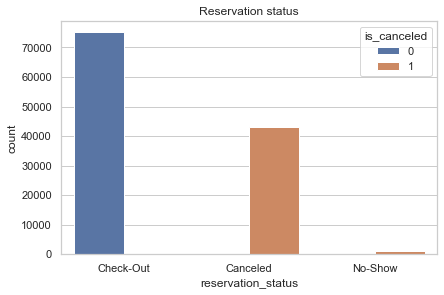

In [8]:
fig, ax = plt.subplots(figsize= (6, 4))
ax.set_title('Reservation status')
sns.countplot(x = 'reservation_status', hue = 'is_canceled', data = hotels, ax = ax)

>Obviously **reservation_status** is dependent of our target feature, and we can say the same about **reservation_status_date** because the timestamp is taken either on cancelation day(prior to arrival) or on the check-out day(after arrival).

In [9]:
# Droping 2 features directly correlated(derived) from target feature
hotels.drop(axis = 1, columns = ['reservation_status', 'reservation_status_date'], inplace = True, errors = 'ignore')
hotels.shape

(119389, 30)

> We will dalso check the nationality aspects of our bookings because the author's comments were specific about a posibility of data leakeage on this feature.
<br><br> Considering there are 178 different countries first we have to reduce the number of categorical values for this feature.


In [10]:
least_categ_replace('country', 3000)

PRT      48589
Other    25260
GBR      12129
FRA      10415
ESP       8568
DEU       7287
ITA       3766
IRL       3375
Name: country, dtype: int64


Text(0.5, 1.0, 'Cancelation by country origin')

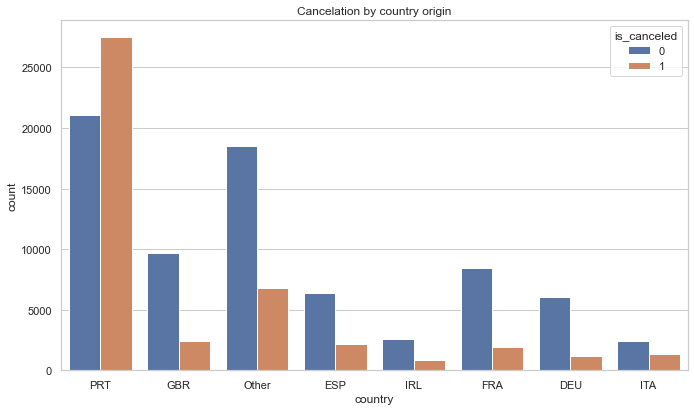

In [11]:
a4_dims = (10, 6)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(x = 'country', hue = 'is_canceled', data = hotels, ax = ax)
plt.title('Cancelation by country origin')

> As we can observe, a very high number of canceled bookings are being atributed to **PRT**. Bookings that fail to show up are often marked as being from the home country, it is not until the arrival that the nationality becomes more accurate. This results in an uneven distribution of canceled bookings from the home country which is innaccurate and misleading for the model.
<br><br> So we consider **country** to be a source of **data leakeage** and we wll remove the feature.

In [12]:
# drop country column to avoid data leakage
hotels.drop('country', axis=1, inplace = True)

>Lastly, the other procedure we have to do to avoid any data leakeage and to obtain a realistic predictive power for our models is the split our data into **train** and **test** before proceeding with other pre-processing operations that might include any aggregation methods.


## 3. Feature engineering - New features

In [13]:
hotels.describe(include='O').T

,count,unique,top,freq
hotel,119389,2,Lisbon City Hotel,79329
arrival_date_month,119389,12,August,13877
meal,119389,5,BB,92309
market_segment,119389,8,Online TA,56477
distribution_channel,119389,5,TA/TO,97869
reserved_room_type,119389,10,A,85993
assigned_room_type,119389,12,A,74052
deposit_type,119389,3,No Deposit,104641
agent,119389,9,Other,36636
company,119389,4,no_company,112592


### 3.1 Creating arrival_day_of_week feature

One information that we can get out of the date features is the day of the week of the arrival. We would want this as a separate feature and we will also use it later in our pre-processing to categorize the customers.

In [14]:
hotels['projected_arrival'] = pd.to_datetime(hotels['arrival_date_year'].astype(str)+'-'\
                                               +hotels['arrival_date_month'].astype(str)+'-'\
                                               +hotels['arrival_date_day_of_month'].astype(str))

In [15]:
hotels['arrival_day_of_week'] = hotels['projected_arrival'].dt.dayofweek

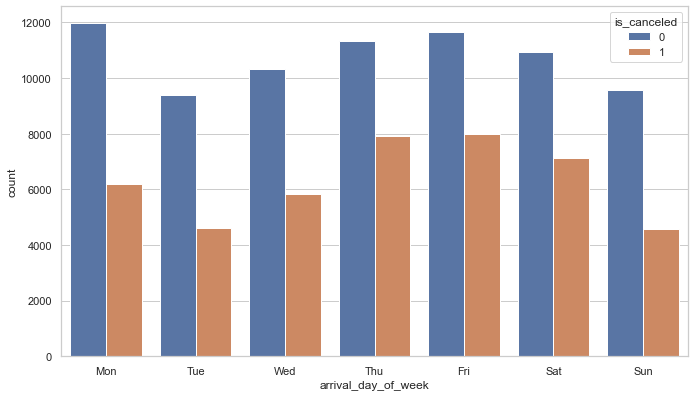

In [16]:
a4_dims = (10, 6)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(x = 'arrival_day_of_week', hue = 'is_canceled', data = hotels, ax = ax)

ticks = list(range(0,7))
labels = "Mon Tue Wed Thu Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.show()

Now let's transform our **arrival_date_month** to integer.

In [17]:
hotels['arrival_date_month'] = hotels['projected_arrival'].dt.month

And drop the newly created **projected_arrival**

In [18]:
# drop assigned_room_type column
hotels.drop('projected_arrival', axis=1, inplace = True)

### 3.2 Creating booking_purpose feature

Using some domain knowledge and using the available data we will create a **booking_purpose** feature for all our bookings

While there might be a lot of different classifications depending on articles or points of views, we will just limit of classification to 3 major classes:
* short_stay - **stays under a day** - stays with 0 week nights and 0 weekend night
* business - **stays for a few week days** - stays containing 1-5  week nights and 0 weekend night
* leisure - **stays for weekend and maybe 1 extra day** - stays containing 0-1 week nights and 1-2 weekend night
* vacation - **stay up to 3 whole weeks** - stays containing 2-15 week nights and 1-7 weekend night
* long_stay - **stays more than 3 weeks** - stays containing 16+ week nights or 8+ weekend night

In [19]:
short_stay = (hotels.stays_in_week_nights == 0) & (hotels.stays_in_weekend_nights == 0)
hotels.loc[short_stay, 'booking_purpose'] = 'short_stay'

business = (hotels.stays_in_week_nights.between(1, 5)) & (hotels.stays_in_weekend_nights == 0)
hotels.loc[business, 'booking_purpose'] = 'business'

leisure = (hotels.stays_in_week_nights.between(0, 1) & (hotels.stays_in_weekend_nights.between(1,2)))
hotels.loc[leisure, 'booking_purpose'] = 'leisure'

vacation = (hotels.stays_in_week_nights.between(2, 15)) & (hotels.stays_in_weekend_nights.between(1,7))
hotels.loc[vacation, 'booking_purpose'] = 'vacation'

long_stay = (hotels.stays_in_week_nights >= 16) | (hotels.stays_in_weekend_nights >= 8)
hotels.loc[long_stay, 'booking_purpose'] = 'long_stay'

hotels.booking_purpose.value_counts()

business      51282
vacation      46446
leisure       20789
short_stay      715
long_stay       157
Name: booking_purpose, dtype: int64

In [20]:
hotels.booking_purpose.isnull().sum()

0

> We covered all posibilities, so our **booking_purpose** feature has no missing values

<AxesSubplot:xlabel='stays_in_week_nights', ylabel='stays_in_weekend_nights'>

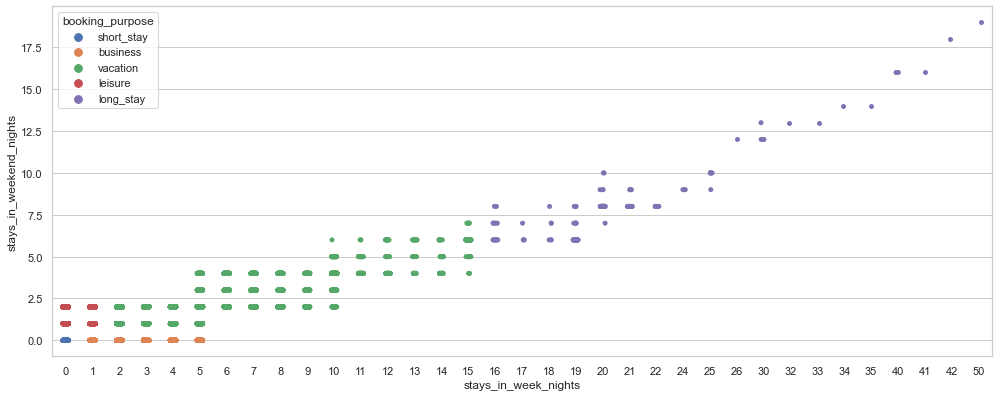

In [21]:
sns.stripplot( data=hotels, x="stays_in_week_nights", y="stays_in_weekend_nights", hue="booking_purpose")

<AxesSubplot:xlabel='booking_purpose', ylabel='count'>

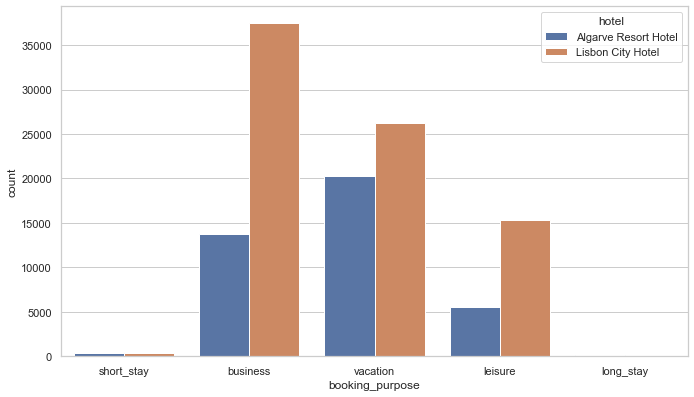

In [22]:
a4_dims = (10, 6)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(x = 'booking_purpose', hue = 'hotel', data = hotels, ax = ax)

> And as expected, the majority of customers went to Algarve Resort for vacation, while most of Lisbon's hotel customers were there with business.

### 3.3 Is there value in having both assigned_room_type and reserved_room_type?
### Creating received_different_room feature

Let's see the difference between what the customers **reserved** and what they were **assigned**.

In [23]:
hotels.reserved_room_type.value_counts() - hotels.assigned_room_type.value_counts()

A                   11941.0
B                   -1045.0
C                   -1443.0
D                   -6121.0
E                   -1271.0
F                    -854.0
G                    -459.0
H                    -111.0
I                       NaN
K                       NaN
L                       5.0
P                       0.0
dtype: float64

In [24]:
print('{}% bookings received a different room from what they reserved'.\
      format(round((hotels.assigned_room_type != hotels.reserved_room_type).mean()*100, 2)))

12.49% bookings received a different room from what they reserved


In [25]:
hotels[(hotels.assigned_room_type != hotels.reserved_room_type)][['assigned_room_type','reserved_room_type']].value_counts()

assigned_room_type  reserved_room_type
D                   A                     7548
C                   A                     1447
E                   A                     1156
B                   A                     1123
E                   D                      686
                                          ... 
C                   L                        1
A                   L                        1
F                   L                        1
D                   H                        1
H                   L                        1
Length: 65, dtype: int64

> It looks like most of the times, the unavailable booked room was a **D, C, E or B** and they received **A** instead. 
<br><br> Let's see if there's a price difference between them.

In [26]:
hotels.groupby('assigned_room_type').mean().adr

assigned_room_type
A                    93.070683
B                    94.450264
C                   113.423583
D                   107.453633
E                   117.704224
F                   151.889931
G                   166.530309
H                   171.380772
I                    40.843774
K                    53.698889
L                     8.000000
P                     0.000000
Name: adr, dtype: float64

<AxesSubplot:xlabel='assigned_room_type', ylabel='adr'>

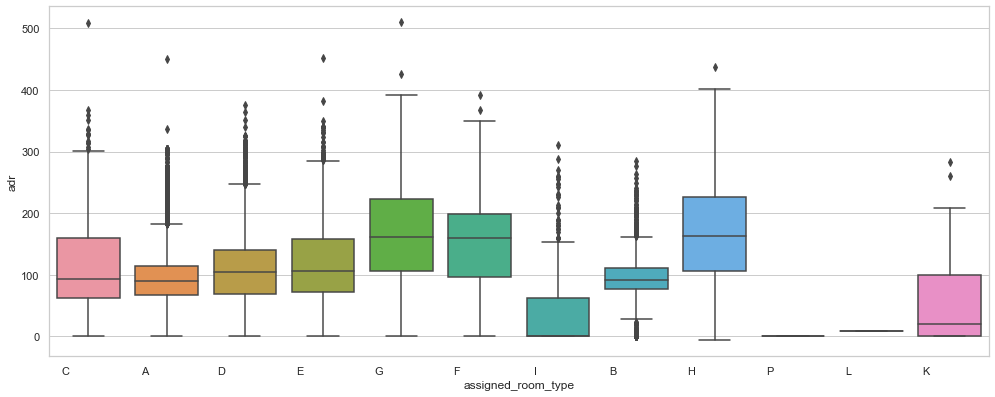

In [27]:
sns.boxplot(x = 'assigned_room_type', y = 'adr', data = hotels)

There are definitely differences between room types when it comes to **adr**.

> With most customers receiving the same room they requested, there is no point in keeping both categorical features.
<br><br> Instead we will create a new binomial feature **received_different_room** and drop **assigned_room_type**

In [28]:
hotels['received_different_room'] = (hotels.assigned_room_type != hotels.reserved_room_type).astype('int')

> We will also reduce the number of categories by keeping just the room types that had more than 1000 records

In [29]:
least_categ_replace('reserved_room_type', 1000)

A                   85993
D                   19201
E                    6535
F                    2897
G                    2094
Other                1551
B                    1118
Name: reserved_room_type, dtype: int64


In [30]:
# drop assigned_room_type column
hotels.drop('assigned_room_type', axis=1, inplace = True)

### 3.4 Binning other categorical features 

Some of the categorical features have values that are uncommon so we will replace all those below a threshold with **Other**.

In [31]:
hotels.describe(include ='O').T

,count,unique,top,freq
hotel,119389,2,Lisbon City Hotel,79329
meal,119389,5,BB,92309
market_segment,119389,8,Online TA,56477
distribution_channel,119389,5,TA/TO,97869
reserved_room_type,119389,7,A,85993
deposit_type,119389,3,No Deposit,104641
agent,119389,9,Other,36636
company,119389,4,no_company,112592
customer_type,119389,4,Transient,89612
booking_purpose,119389,5,business,51282


In [32]:
for feature in ['meal', 'market_segment', 'distribution_channel']:
    least_categ_replace(feature, 5000)
    hotels[feature].value_counts()

BB           92309
HB           14463
SC           10650
Other         1967
Name: meal, dtype: int64
Online TA        56477
Offline TA/TO    24218
Groups           19811
Direct           12606
Corporate         5295
Other              982
Name: market_segment, dtype: int64
TA/TO        97869
Direct       14645
Corporate     6677
Other          198
Name: distribution_channel, dtype: int64


In [33]:
hotels.describe(include ='O').T.index

Index(['hotel', 'meal', 'market_segment', 'distribution_channel',
       'reserved_room_type', 'deposit_type', 'agent', 'company',
       'customer_type', 'booking_purpose'],
      dtype='object')

In [34]:
hotels.describe(exclude ='O').T

,count,mean,std,min,25%,50%,75%,max
is_canceled,119389.0,0.370411,0.482917,0.00,0.00,0.00,1.0,1.0
lead_time,119389.0,104.011994,106.863358,0.00,18.00,69.00,160.0,737.0
arrival_date_year,119389.0,2016.156555,0.707479,2015.00,2016.00,2016.00,2017.0,2017.0
arrival_date_month,119389.0,6.552513,3.090615,1.00,4.00,7.00,9.0,12.0
arrival_date_week_number,119389.0,27.165292,13.605134,1.00,16.00,28.00,38.0,53.0
arrival_date_day_of_month,119389.0,15.798164,8.780826,1.00,8.00,16.00,23.0,31.0
stays_in_weekend_nights,119389.0,0.927606,0.998614,0.00,0.00,1.00,2.0,19.0
stays_in_week_nights,119389.0,2.500314,1.908289,0.00,1.00,2.00,3.0,50.0
adults,119389.0,1.856402,0.579263,0.00,2.00,2.00,2.0,55.0
children,119389.0,0.103887,0.398557,0.00,0.00,0.00,0.0,10.0


There are some numerical features that are heavily skewed to left with the majority of values at **0**. We have a series of tools to transform them:
 * Binomial binning
 * Logarithmic transformation
 * StandardScaler

We will leave those as they are for now and will come back to them after our iniatial modeling.

## 4. Customer segmentation - Unsupervised learning 

For the purpose of our customer segmentation we will only select the features that are relevant for our customer unsupervised clustering.

We will use these numerical features from our data:
   * lead_time
   * arrival_date_week_number
   * adults
   * children
   * babies
   * is_repeated_guest
   * previous_cancellations
   * previous_bookings_not_canceled
   * booking_changes
   * adr
   * arrival_day_of_week

And all the categorical features: ['hotel', 'meal', 'market_segment', 'distribution_channel',
       'reserved_room_type', 'deposit_type', 'agent', 'company',
       'customer_type', 'booking_purpose']

In [35]:
hotels_clustering = hotels[['is_canceled', 'hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type',
                         'agent', 'company', 'customer_type', 'booking_purpose', 'lead_time', 'arrival_date_week_number', 
                         'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations',
                         'previous_bookings_not_canceled', 'booking_changes', 'adr', 'arrival_day_of_week']]

### 4.1 Encoding Categorical Features 

**This is where I am stuck at the moment.**

I still need to do:
- get_dummies on categorical data
- scale data with Standard Scaler(on the whole DataFrame?)( i remember not having to do that - initially use data without scaling)
- train_test_split
- do the unsupervised clustering

In [36]:
#Dealing with numerical data
hotels_clustering.describe(include ='O').T

,count,unique,top,freq
hotel,119389,2,Lisbon City Hotel,79329
meal,119389,4,BB,92309
market_segment,119389,6,Online TA,56477
distribution_channel,119389,4,TA/TO,97869
reserved_room_type,119389,7,A,85993
deposit_type,119389,3,No Deposit,104641
agent,119389,9,Other,36636
company,119389,4,no_company,112592
customer_type,119389,4,Transient,89612
booking_purpose,119389,5,business,51282


In [37]:
hotels_clustering_num = pd.get_dummies(hotels_clustering, drop_first=True)

In [38]:
hotels_clustering_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119389 entries, 0 to 119388
Data columns (total 50 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   is_canceled                          119389 non-null  int64  
 1   lead_time                            119389 non-null  int64  
 2   arrival_date_week_number             119389 non-null  int64  
 3   adults                               119389 non-null  int64  
 4   children                             119389 non-null  float64
 5   babies                               119389 non-null  int64  
 6   is_repeated_guest                    119389 non-null  int64  
 7   previous_cancellations               119389 non-null  int64  
 8   previous_bookings_not_canceled       119389 non-null  int64  
 9   booking_changes                      119389 non-null  int64  
 10  adr                                  119389 non-null  float64
 11  arrival_day_o

### 4.2 Train test split

Even if we are conducting unsupervised learning, before continuing with our modeling we have to make sure that we are preventing **data leakeage** from our training data to our testing data to maximize the predictive power of our models.

In [39]:
# Split data into features and label
# features X_cluster
X = hotels_clustering_num.drop('is_canceled', axis=1)
        
# Label y
y = hotels_clustering_num['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

### 4.3 KMeans on raw data

We will first define a function that will have our training data and maximum number of clusters, it will process the KMeans modelling and will output the Inertias graph.

In [40]:
def clustering_plotting_elbow(df, n = 10):
    ks = range(1,n+1)
    inertias = []
    for k in ks:
        model = KMeans(n_clusters = k, random_state = 123)
        model.fit(df)
        inertias.append(model.inertia_)

    plt.plot(ks, inertias, '-o')
    plt.xlabel('Number of Clusters, k')
    plt.ylabel('Inertia')
    plt.xticks(ks)
    plt.show()

We will create another fucntion to be able to visualize the silhoutte scoring and clusters

In [41]:
def plotting_silhouette(df, n = 6):
    range_n_clusters = list(range(2,n+1))

    for n_clusters in range_n_clusters:
        fig, ax1 = plt.subplots(1,1)
        fig.set_size_inches(18, 7)
# The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate 
# them clearly.
        ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator seed of 123 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=123)
        cluster_labels = clusterer.fit_predict(df)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(df, cluster_labels)
        print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(df, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
# Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values =  sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, 
                              edgecolor=color, alpha=0.7)

# Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

# Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

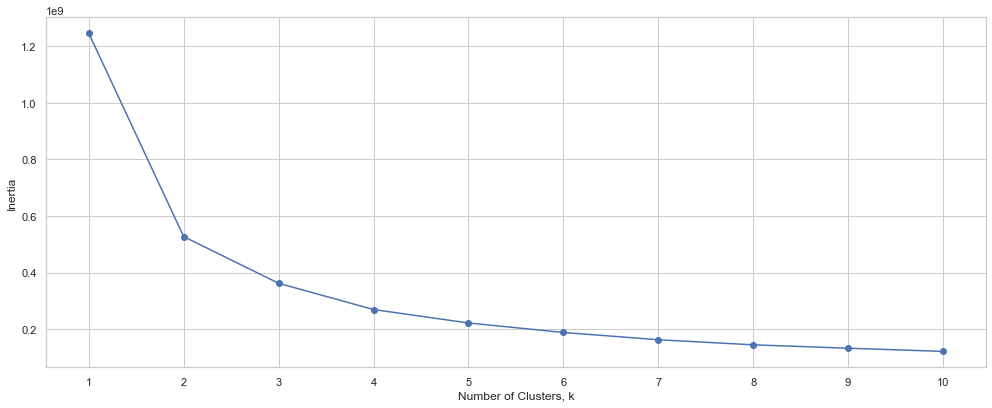

In [42]:
clustering_plotting_elbow(X_train, 10)

Using the **Elbow method** we are estimating the optimal number of clusters to be 2.

For n_clusters = 2 The average silhouette_score is : 0.5353149352905746
For n_clusters = 3 The average silhouette_score is : 0.4290141111617016
For n_clusters = 4 The average silhouette_score is : 0.39308834600714887
For n_clusters = 5 The average silhouette_score is : 0.3810518356349841
For n_clusters = 6 The average silhouette_score is : 0.3571291192764286


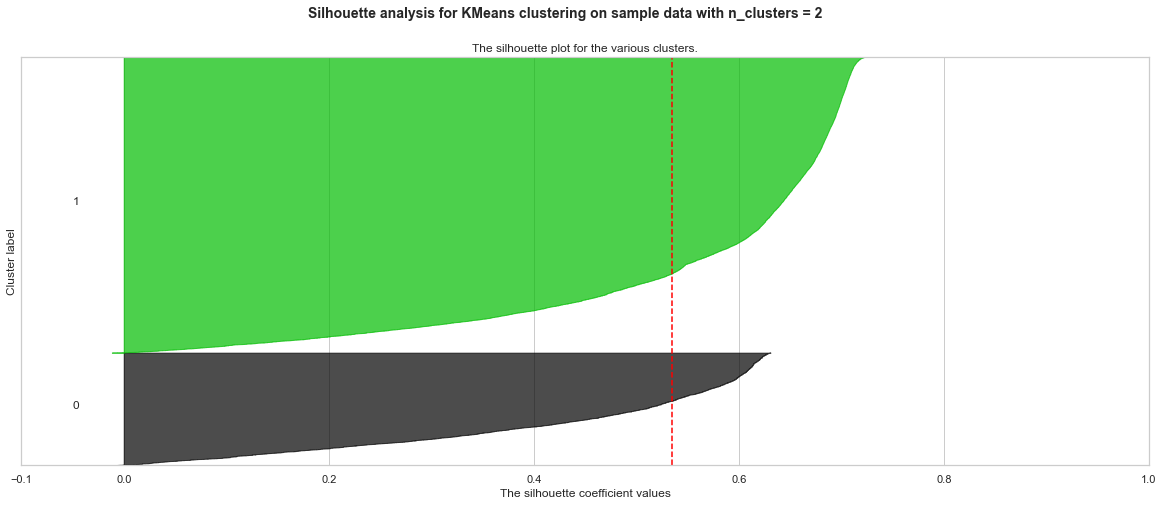

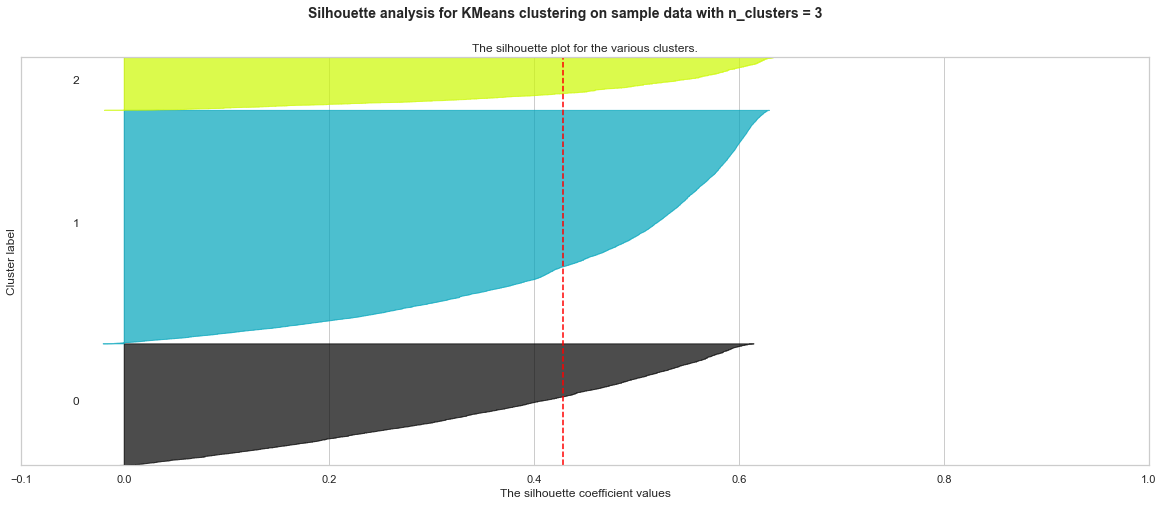

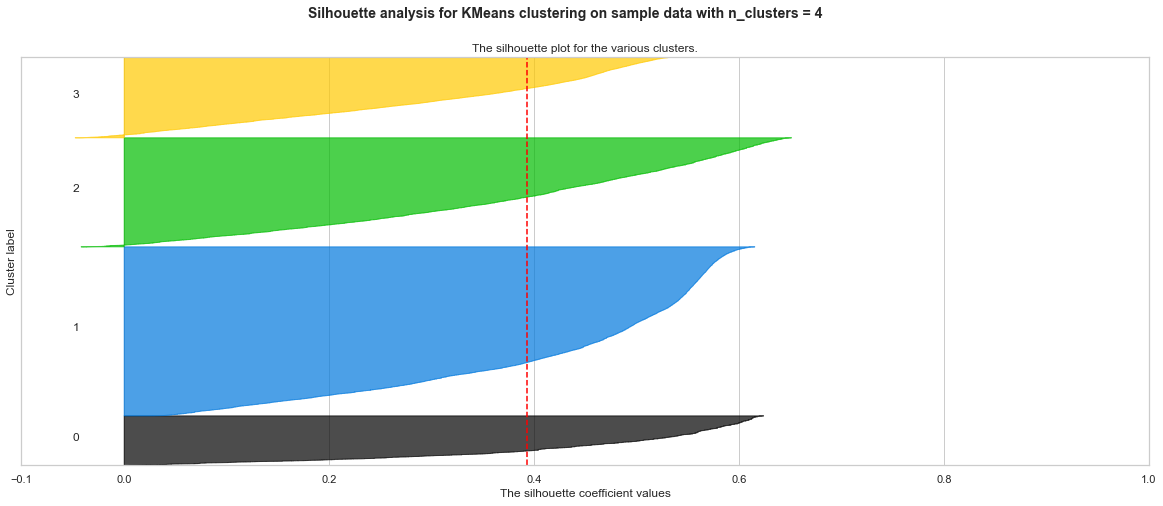

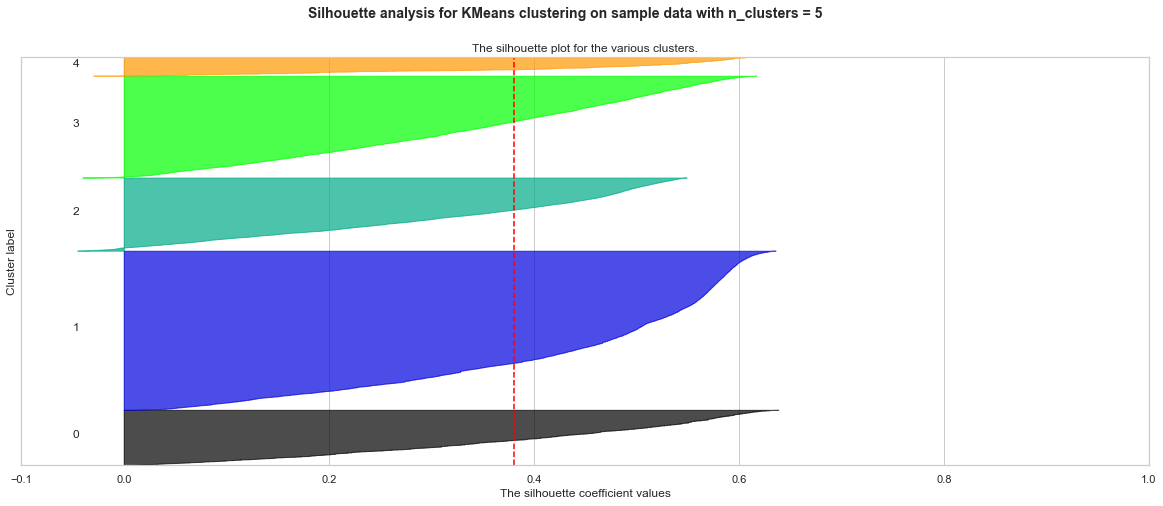

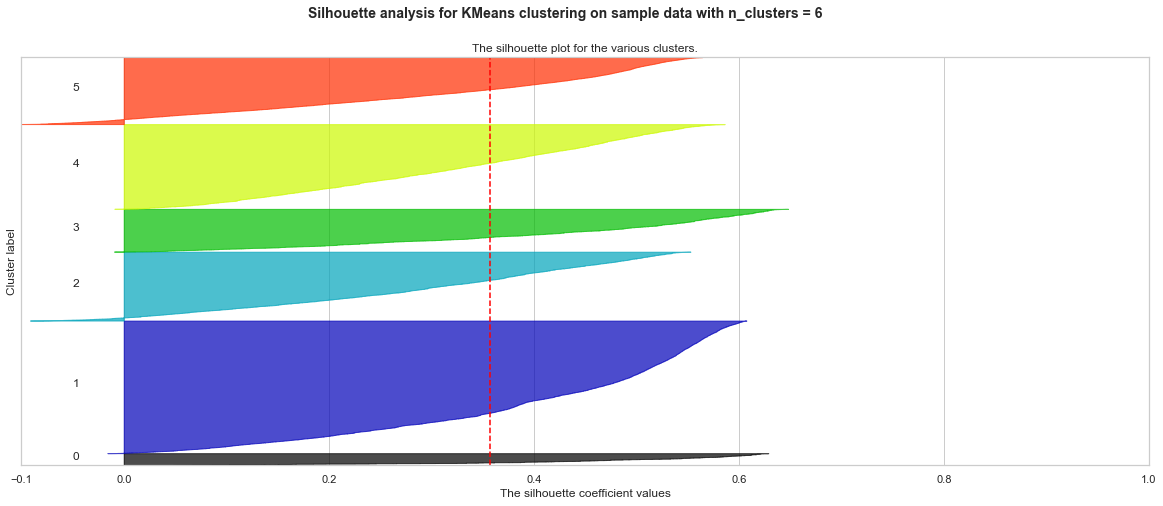

In [43]:
plotting_silhouette(X_train, 6)

The value of n_clusters as 5 and 6 looks to be suboptimal for the given data because of the wide fluctuations in the size of the silhouette plots as we have clusters that are considerably smaller than other clusters.

The value of 2,3 and 4 for n_clusters looks to be the optimal ones. The silhouette score for each cluster is above average silhouette scores. Also, the fluctuation in size is similar. 

The thickness of the silhouette plot representing each cluster also is a deciding point. For the plot with n_cluster 4, the thickness is more uniform than the plots with n_cluster as 2 or 3 where one cluster thickness is much more than others. Thus, we can select the optimal number of clusters as 4.

### 4.5 Clustering after scaling

Now lets use a standard scaler and see the results


In [44]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

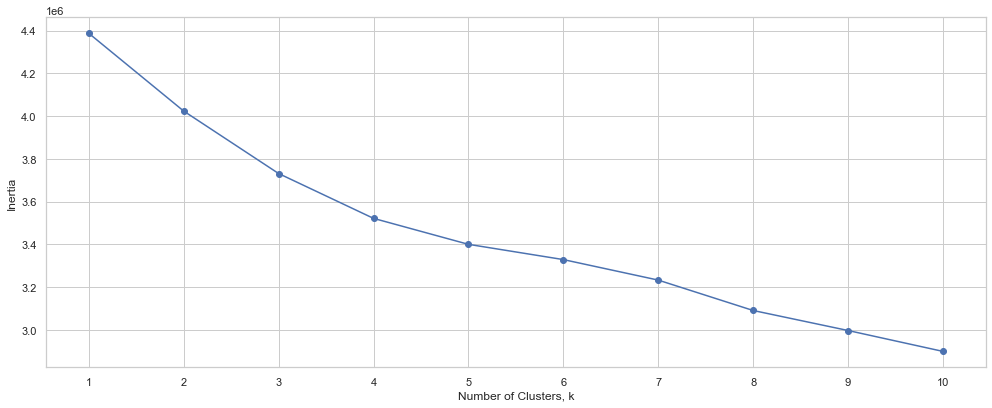

In [45]:
clustering_plotting_elbow(X_train_scaled, 10)

Using the **Elbow** method we don't have any obvious choices, but are estimating the optimal number of clusters would be 4 or 5.

For n_clusters = 2 The average silhouette_score is : 0.2569508435615243
For n_clusters = 3 The average silhouette_score is : 0.11253907707395579
For n_clusters = 4 The average silhouette_score is : 0.13264970075366783
For n_clusters = 5 The average silhouette_score is : 0.13999638038942847
For n_clusters = 6 The average silhouette_score is : 0.1321686531093396


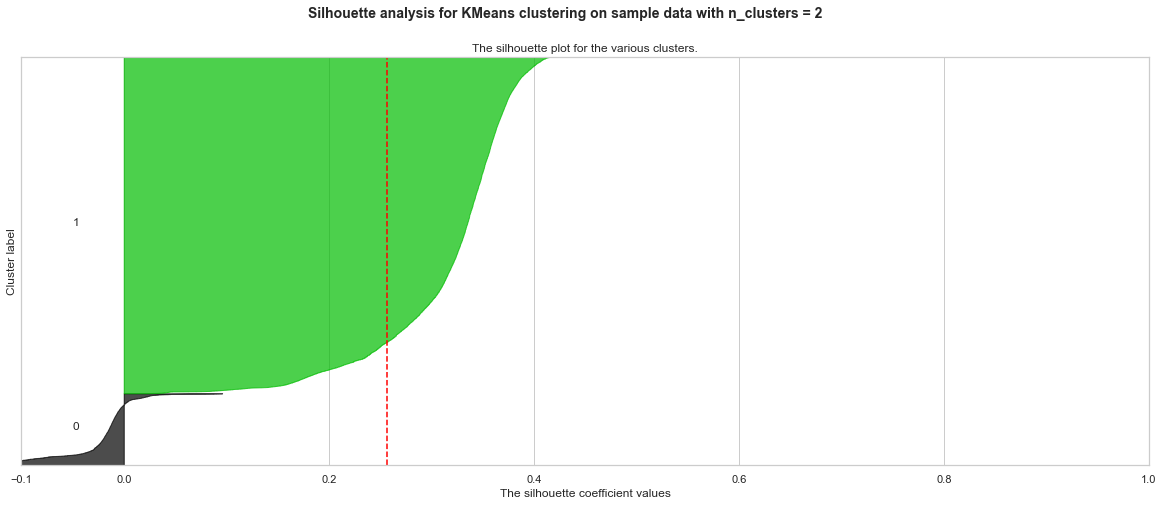

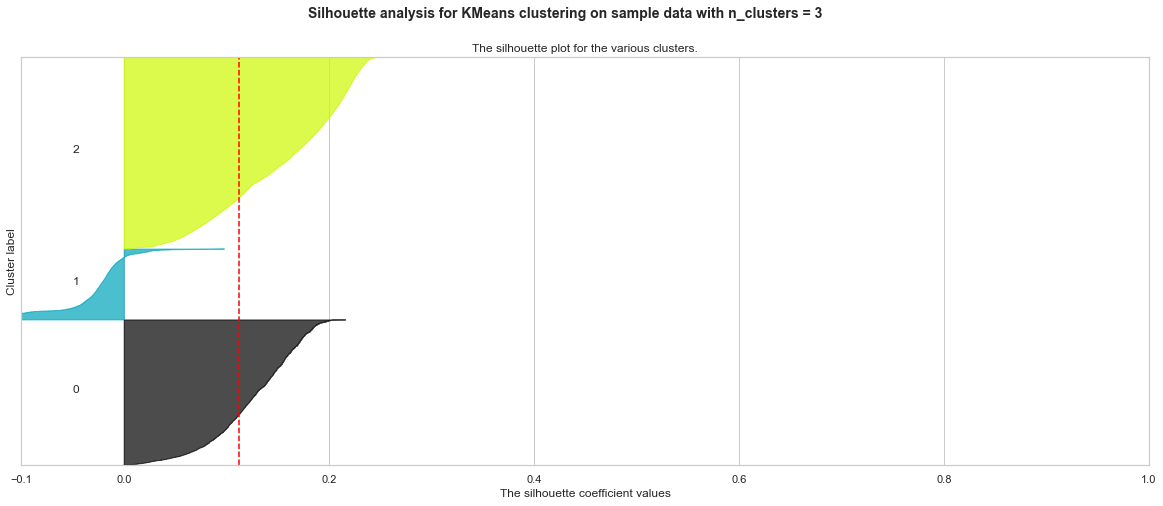

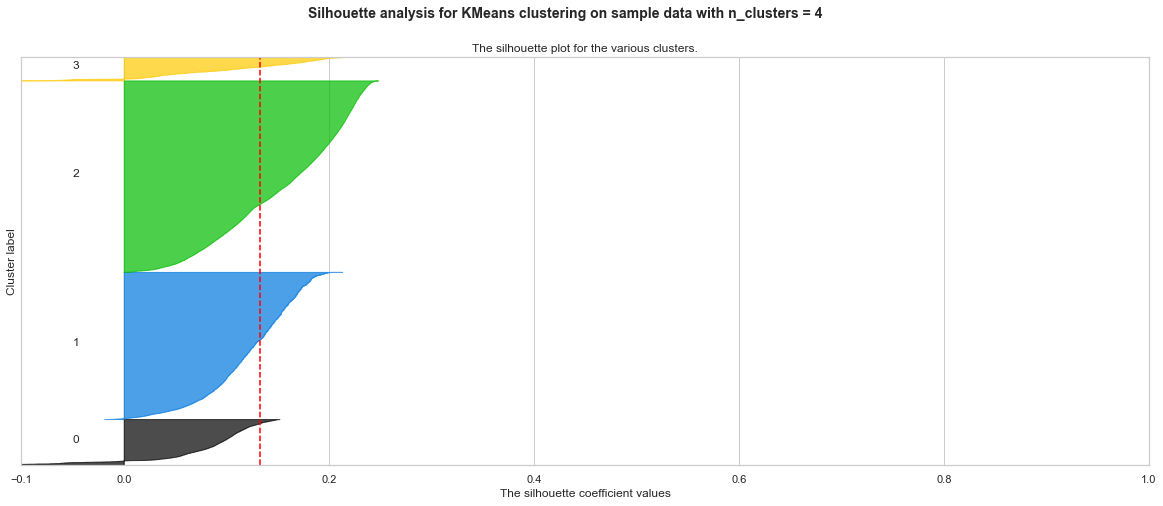

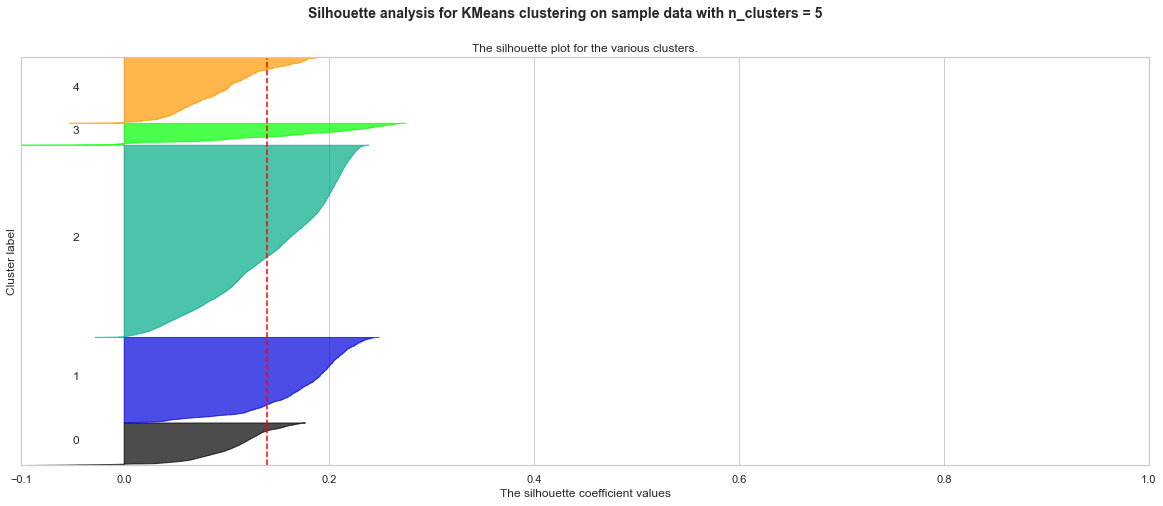

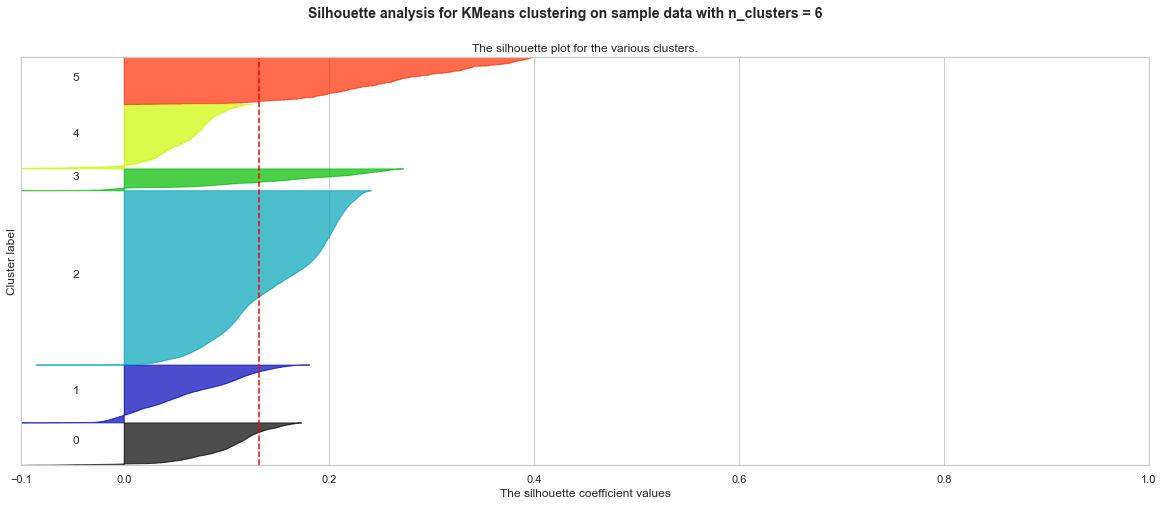

In [46]:
plotting_silhouette(X_train_scaled, 6)

Analyzing the silhouette scores and plots, we see that the Clustering after using the StandardScaler is worse that without, up to a point that the grouping seems inconclusive.

The only plots that seem to have more uniform thickness in their clusters are the clusterings around 4 and 5 clusters, but even then we see that the silhouette score is 0.13, which means that there are no underlying clusters in our data.

### 4.6 Clustering after PCA

Another thing we can do is to use the PCA to reduce the dimensionality of our data.

PCA is affected by scale so we are doing the Principal Component Analysis on our scaled data.

In [47]:
PCA_model = PCA()
PCA_model.fit(X_train_scaled)

features = range(PCA_model.n_components_)

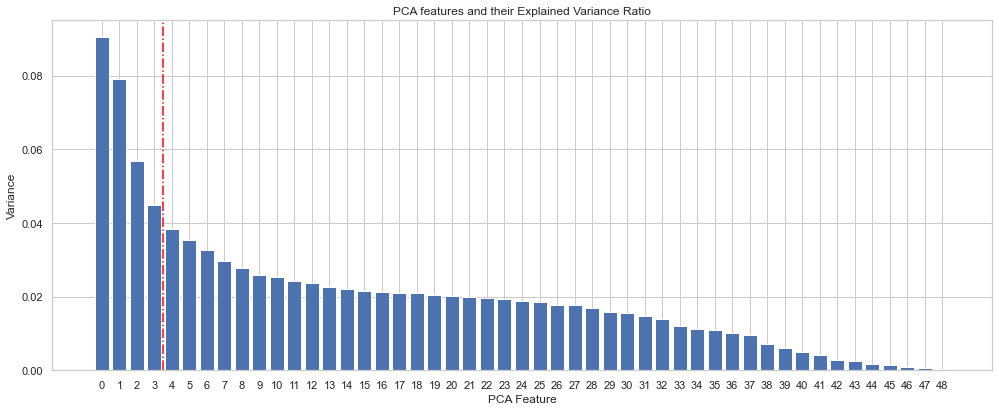

In [48]:
plt.bar(features, PCA_model.explained_variance_ratio_)
plt.axvline(3.5, c = 'red', linestyle = '-.')
plt.xticks(features)
plt.ylabel('Variance')
plt.xlabel('PCA Feature')
plt.title('PCA features and their Explained Variance Ratio')
plt.show()

Text(0.5, 1.0, 'Cummulative PCA features with a 90% explained variance ratio threshold" ')

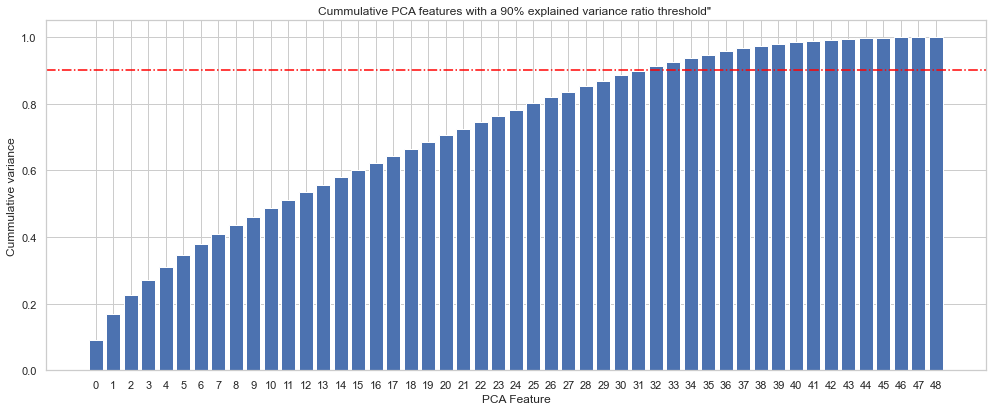

In [49]:
#cummulative plot
plt.bar(features, np.cumsum(PCA_model.explained_variance_ratio_))
plt.axhline(.9, c = 'red', linestyle = '-.', label = '')
plt.xticks(features)
plt.ylabel('Cummulative variance')
plt.xlabel('PCA Feature')
plt.title('Cummulative PCA features with a 90% explained variance ratio threshold" ')

For our Unsupervised Clustering algorithm we will use just **the first 4 Principal Components.**

Let's plot the heatmap of these 4 PCA features to see how impactful were the initial features in forming these principal components.

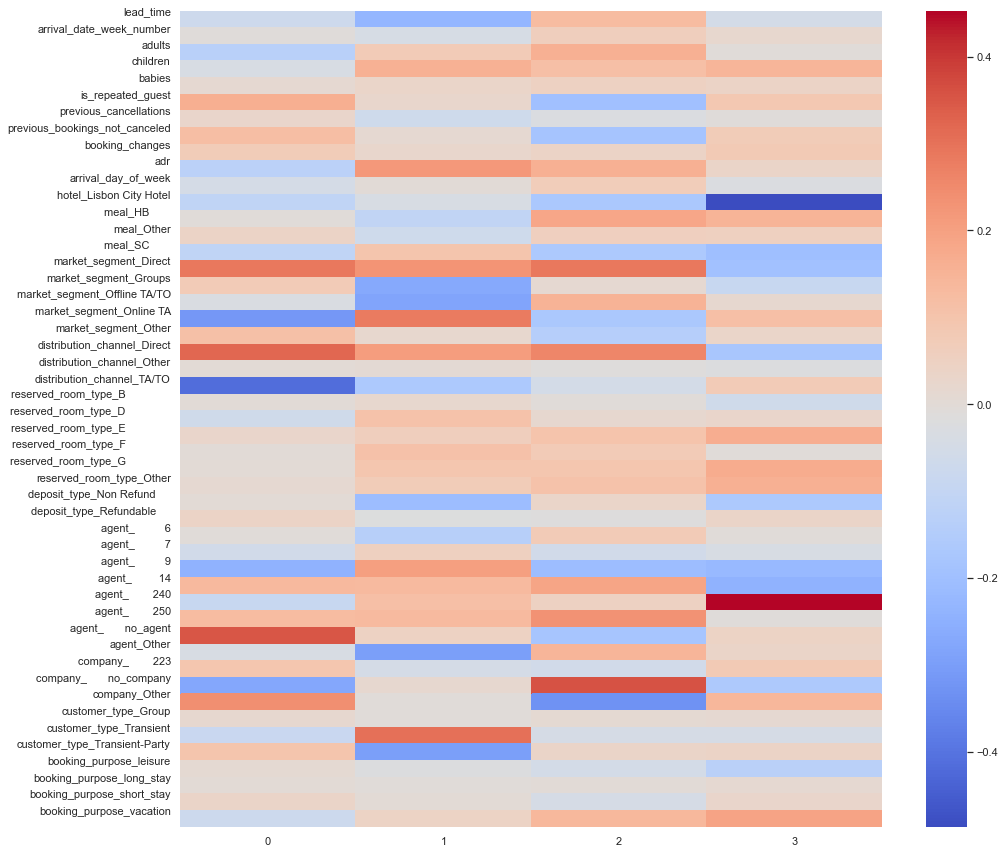

In [50]:
fig, ax = plt.subplots(1,1, figsize = (14,14))

sns.heatmap(PCA_model.components_[0:4].T, cmap = 'coolwarm')
plt.yticks(range(49), X_train.columns, rotation = 0)
plt.show()

In [51]:
X_train_pca = PCA_model.transform(X_train_scaled)
X_train_pca.shape

(89541, 49)

We will use just the most representative 4 PCA features for our further KMeans modelling.

In [52]:
X_train_pca = X_train_pca[:,0:4]
X_train_pca.shape

(89541, 4)

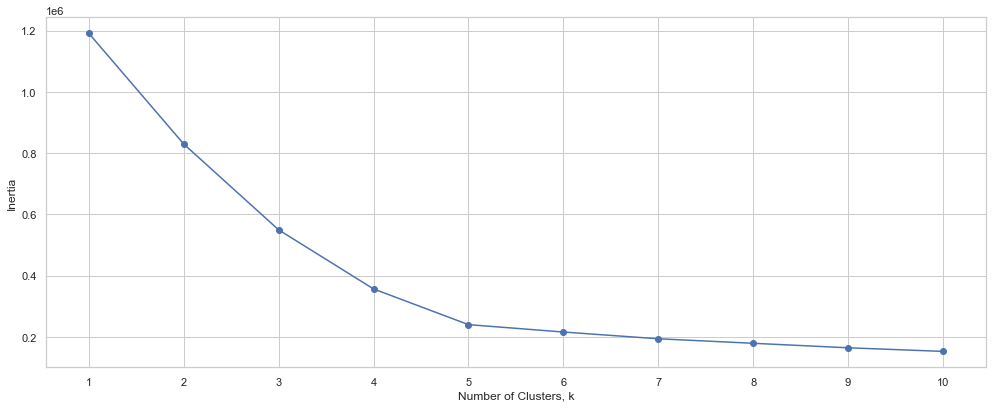

In [53]:
clustering_plotting_elbow(X_train_pca, 10)

Using the **Elbow** method we are estimating the optimal number of clusters would be **5**.

For n_clusters = 2 The average silhouette_score is : 0.4758166007653855
For n_clusters = 3 The average silhouette_score is : 0.44452511390222194
For n_clusters = 4 The average silhouette_score is : 0.49483987143320063
For n_clusters = 5 The average silhouette_score is : 0.5427177449861779
For n_clusters = 6 The average silhouette_score is : 0.4677257498548569


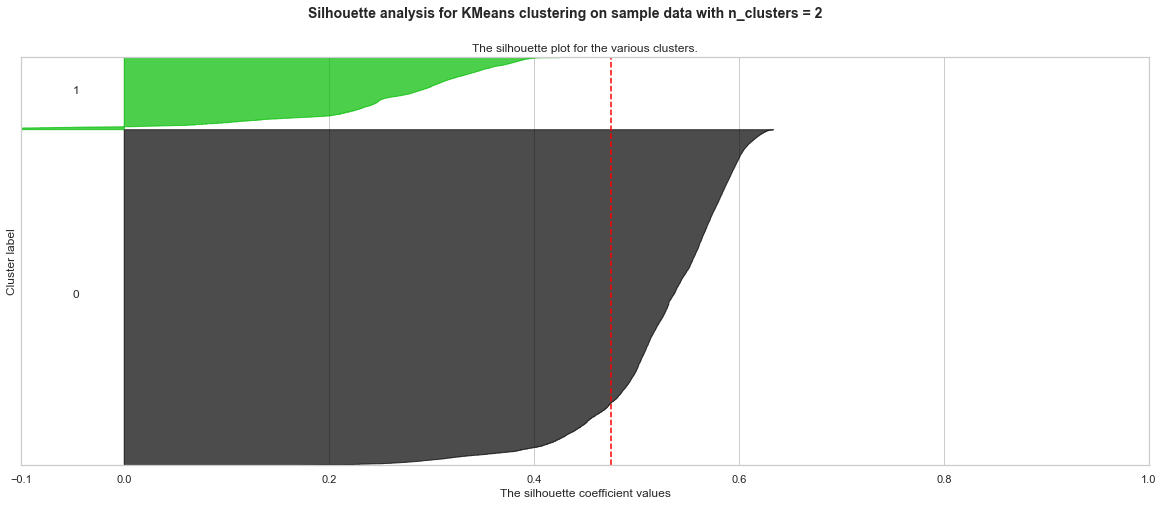

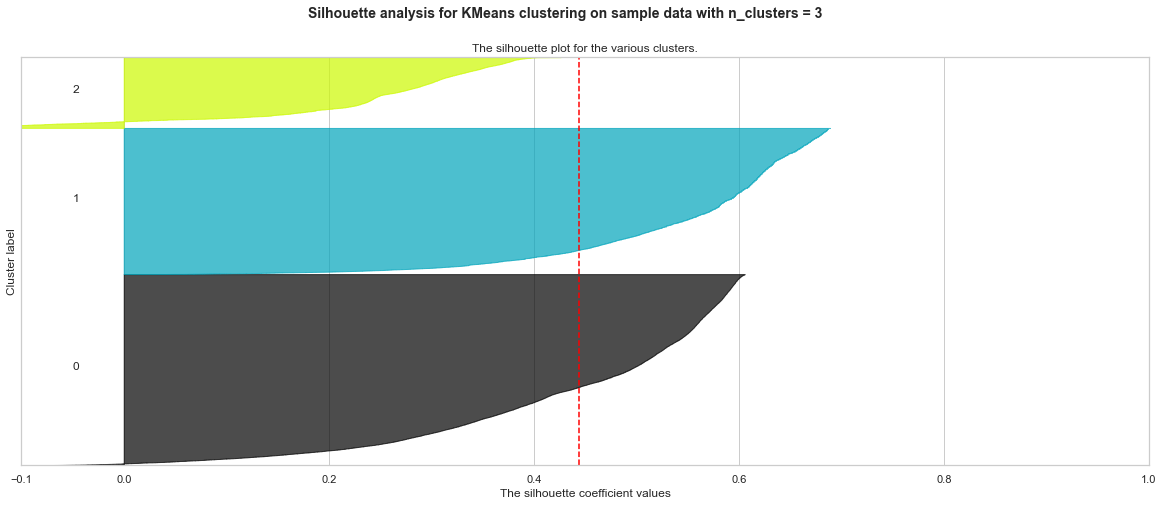

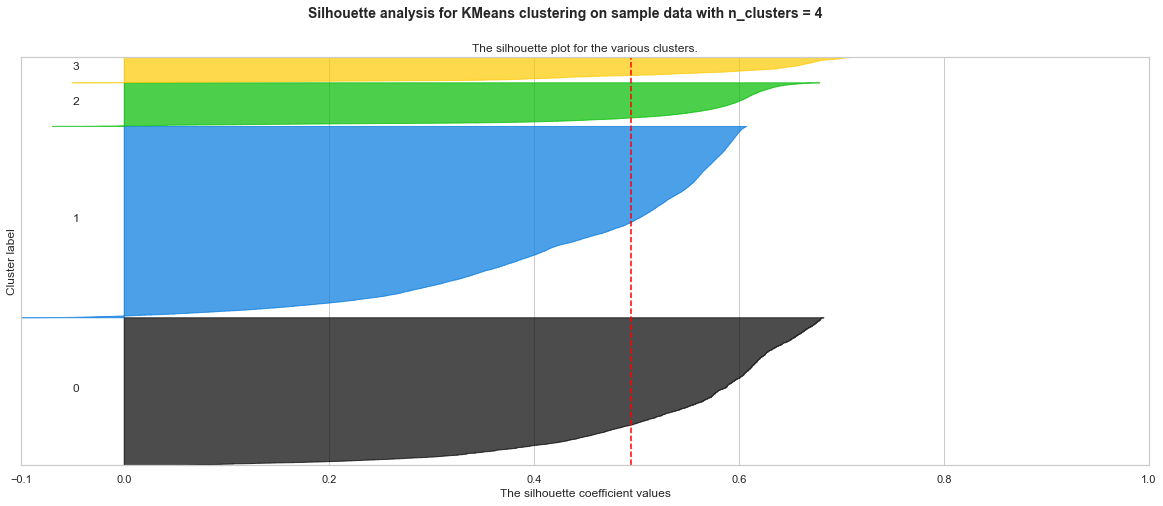

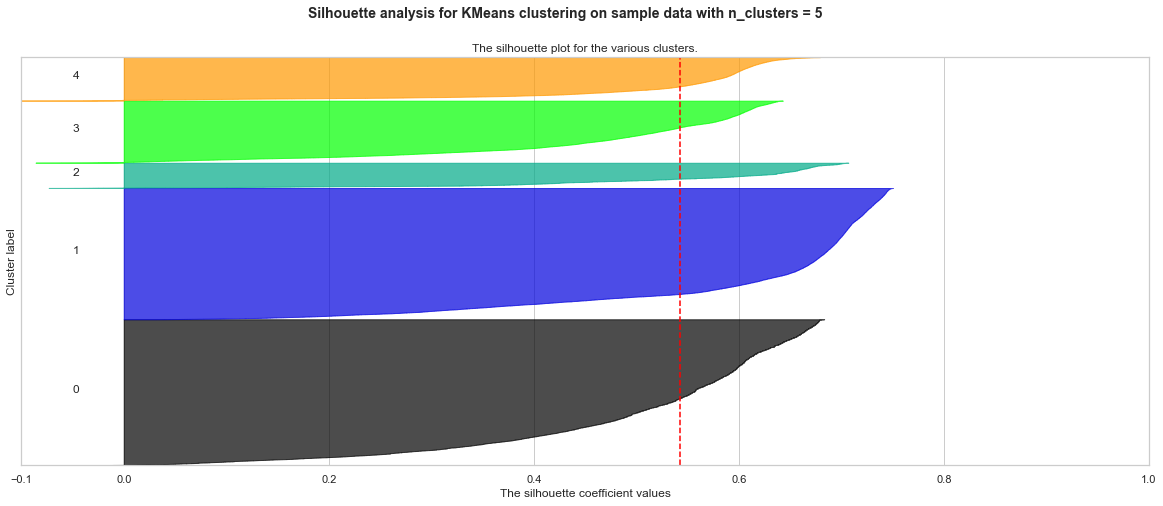

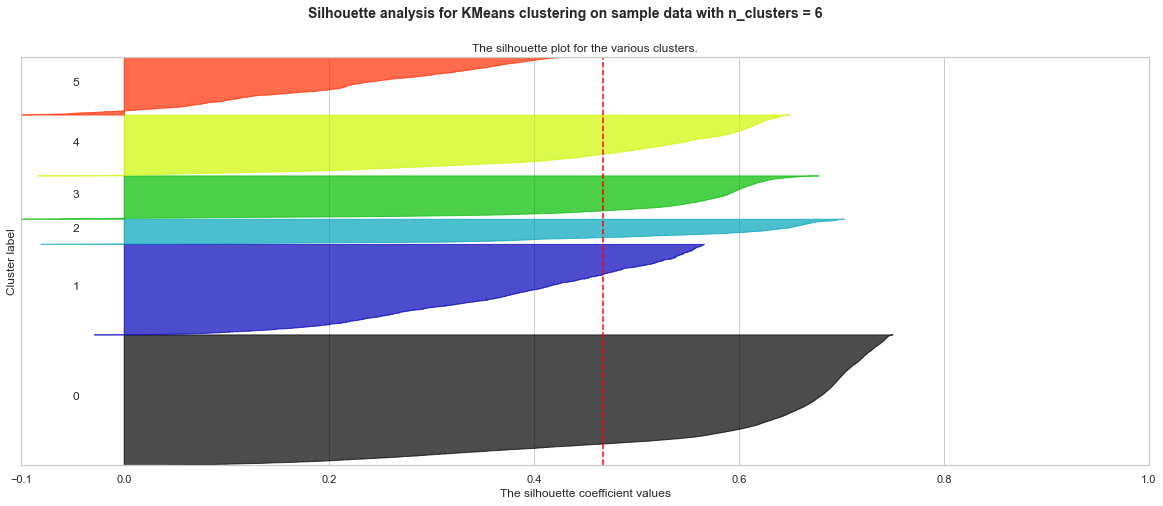

In [54]:
plotting_silhouette(X_train_pca, 6)

The Silhouette scores after PCA are overall better that the scores from our raw data.
The optimal clustering consideing plot thickness and score is the clustering with 5 clusters, with a **0.54 Silhouette score**.

Let's plot the 2 PCA features used using our KMeans labels.

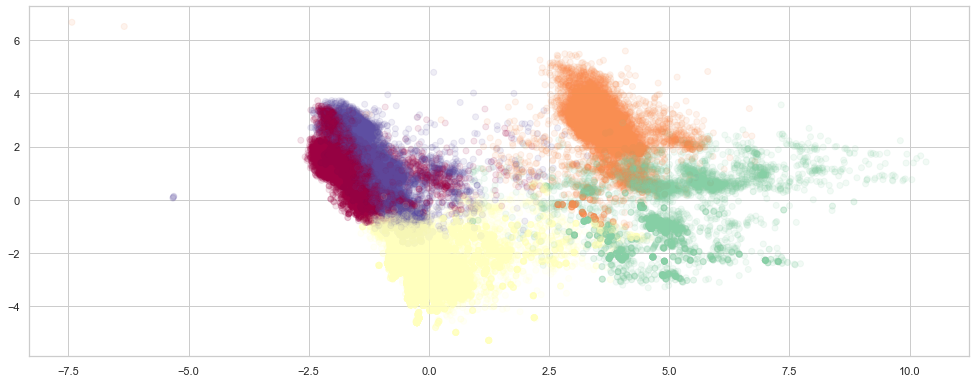

In [55]:
KMeans_model = KMeans(n_clusters = 5)
KMeans_model.fit(X_train_pca)
labels = KMeans_model.predict(X_train_pca)

plt.scatter(X_train_pca[:,0],X_train_pca[:,1], alpha = 0.1, c = labels, cmap = 'Spectral')

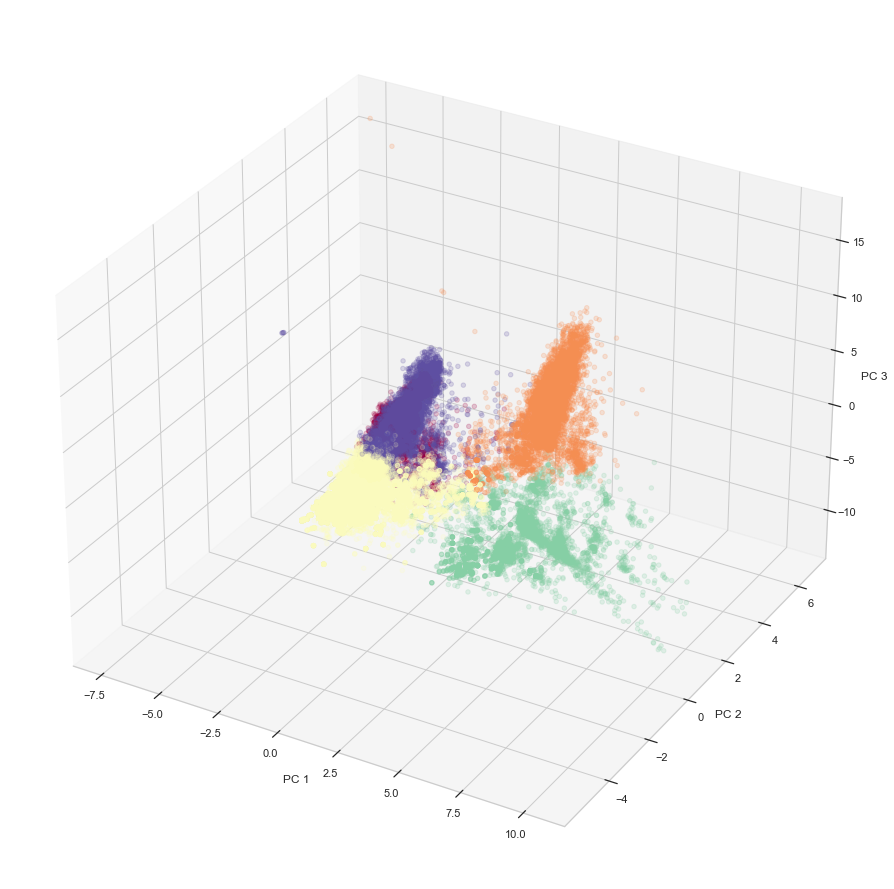

In [56]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection = '3d')

x = X_train_pca[:,0]
y = X_train_pca[:,1]
z = X_train_pca[:,2]

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")

ax.scatter(x, y, z, c = labels, alpha = 0.2, cmap = 'Spectral')

plt.show()

### 4.7 Selecting the model. Apply the pipeline to whole data

We will create and apply a pipeline containing the Scaler, PCA and KMeans clustering.

In [57]:
scaler = StandardScaler()
pca_model = PCA_model = PCA(n_components = 4)
KMeans_model = KMeans(n_clusters = 5)

pipeline = make_pipeline(scaler, pca_model, KMeans_model)
pipeline.fit(X_train)
labels = pipeline.predict(X)
labels.shape

(119389,)

And now we will asign the new labels to a new feature in our dataset.

In [58]:
hotels['cust_segmentation'] = labels.astype('str')

In [59]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119389 entries, 0 to 119388
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119389 non-null  object 
 1   is_canceled                     119389 non-null  int64  
 2   lead_time                       119389 non-null  int64  
 3   arrival_date_year               119389 non-null  int64  
 4   arrival_date_month              119389 non-null  int64  
 5   arrival_date_week_number        119389 non-null  int64  
 6   arrival_date_day_of_month       119389 non-null  int64  
 7   stays_in_weekend_nights         119389 non-null  int64  
 8   stays_in_week_nights            119389 non-null  int64  
 9   adults                          119389 non-null  int64  
 10  children                        119389 non-null  float64
 11  babies                          119389 non-null  int64  
 12  meal            

### 4.8 Visualizing the customer segmentation

Let's create some graphs to visualize the customer segmentation

<AxesSubplot:xlabel='cust_segmentation', ylabel='adr'>

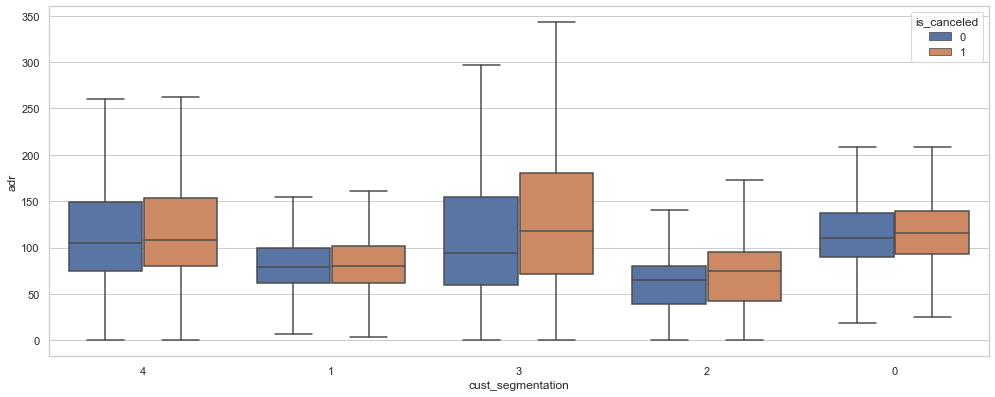

In [60]:
sns.boxplot(x = 'cust_segmentation', y = 'adr', hue = 'is_canceled', data = hotels, sym ="")

<AxesSubplot:xlabel='cust_segmentation', ylabel='count'>

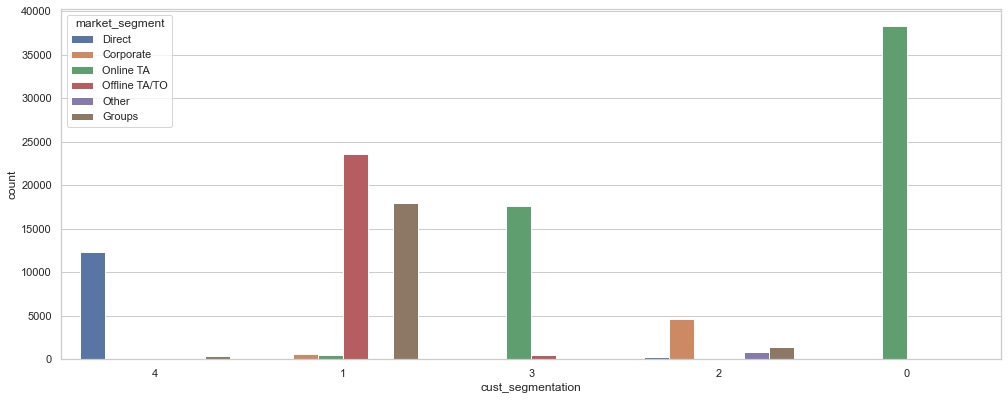

In [61]:
sns.countplot( data=hotels, hue="market_segment",x = "cust_segmentation")

We can see that a lot of clustering took place around the market_segment feature.

<AxesSubplot:xlabel='cust_segmentation', ylabel='count'>

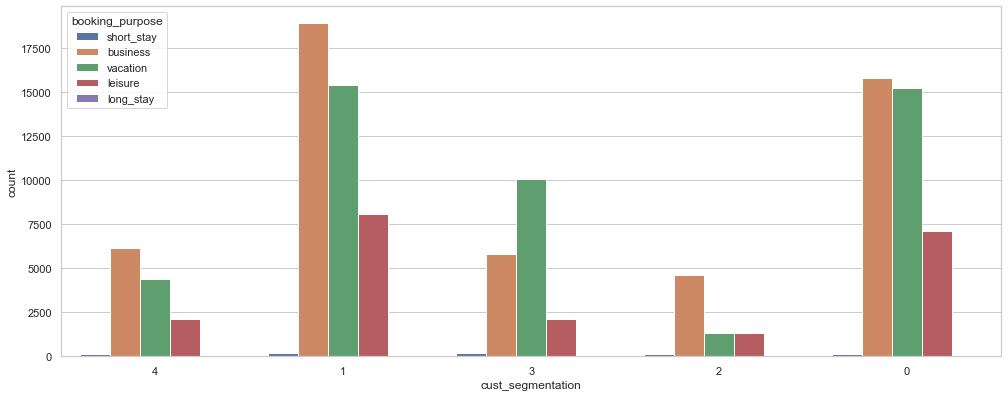

In [62]:
sns.countplot(hue = 'booking_purpose', x = 'cust_segmentation', data = hotels)

## 5. Saving data

Saving the Clustering model

In [65]:
best_clustering_model = pipeline
best_clustering_model.version = '1.0'
best_clustering_model.pandas_version = pd.__version__
best_clustering_model.numpy_version = np.__version__
best_clustering_model.sklearn_version = sklearn_version
best_clustering_model.X_columns = [col for col in X_train.columns]
best_clustering_model.build_datetime = datetime.datetime.now()

In [66]:
filename = '../models/KMeans_clustering_pipeline.sav'
pickle.dump(best_clustering_model, open(filename, 'wb'))

Saving the **hotels** DataFrame after pre-processing

In [67]:
# Saving data to interim folder
hotels.to_csv('../data/interim/hotels_for_modeling.csv')